In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [2]:
home = pd.read_csv('./datasets/train.csv')

In order to make sorting / calling / organizing easier, I'm going to make all columns lowercase and remove spaces.

In [3]:
home.columns = [col.lower().replace(' ', '_') for col in home.columns]

In [4]:
home.head(1)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


Okay, that looks good!

# Categorical Considerations
I studied the categorical columns, highlighted those which I found most intriguing, then evaluated them 1 by 1 (below).

### MSZoning: Identifies the general zoning classification of the sale.

-   A Agriculture

-   C Commercial

-   FV Floating Village Residential

-   I Industrial

-   RH Residential High Density

-   RL Residential Low Density

-   RP Residential Low Density Park

-   RM Residential Medium Density

In [5]:
home['ms_zoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [ ]:
#https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid

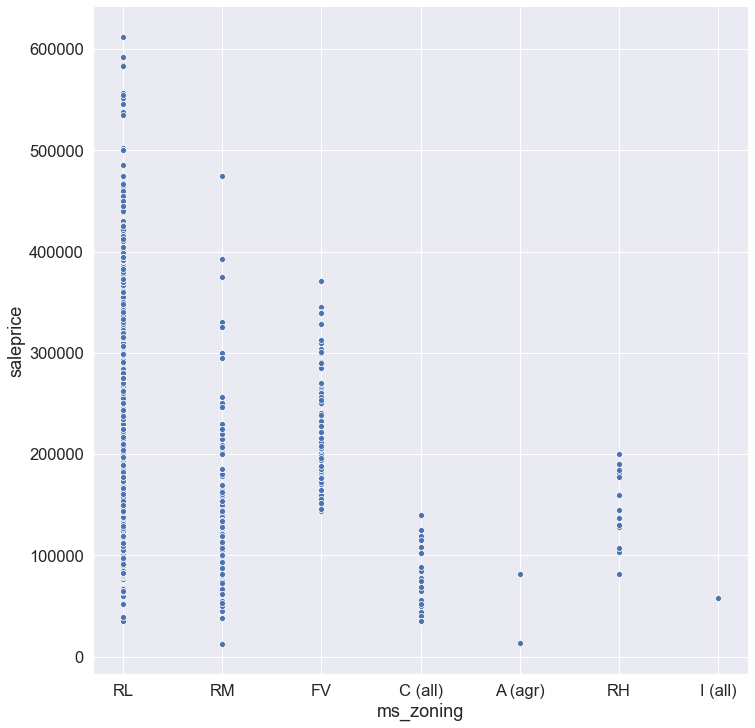

In [103]:
sns.set(font_scale=1.5)
sns.pairplot(home, y_vars='saleprice', x_vars=['ms_zoning'], height=10);
#plt.savefig('msz_pairplot.png', dpi=200, bbox_inches='tight');

Looks like a decent distribution - I might want to combine some of the lower quantity values so I don't get caught with a meaninglessly small indicator. Worth testing.  No RP so I'll put it in with the largest ranged distribution (RL)
- I (all), A (agr), C (all)
- RH
- FV
- RM
- RL, RP

### Neighborhood: Physical locations within Ames city limits

-   Blmngtn Bloomington Heights

-   Blueste Bluestem

-   BrDale Briardale

-   BrkSide Brookside

-   ClearCr Clear Creek

-   CollgCr College Creek

-   Crawfor Crawford

-   Edwards Edwards

-   Gilbert Gilbert

-   IDOTRR Iowa DOT and Rail Road

-   MeadowV Meadow Village

-   Mitchel Mitchell

-   Names North Ames

-   NoRidge Northridge

-   NPkVill Northpark Villa

-   NridgHt Northridge Heights

-   NWAmes Northwest Ames

-   OldTown Old Town

-   SWISU South & West of Iowa State University

-   Sawyer Sawyer

-   SawyerW Sawyer West

-   Somerst Somerset

-   StoneBr Stone Brook

-   Timber Timberland

-   Veenker Veenker

In [7]:
home['neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
Timber      48
NoRidge     48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

Again, may need to combine some columns but this is a fairly good distribution and almost certainly valuable. Neighborhood reputation / brands, whether truly earned or merely imagined, have an impact on homebuyer's choices. Any neighborhood with less than 25 representatives will be combined with the next closest neighborhood.
Some obvious combo geographic based on neighborhood map (thanks Hov): https://files.slack.com/files-pri/T0351JZQ0-F01BD7FCN3Z/image.png

GrnHill + Timber  
Greens + Veenker  
Blueste + Crawfor  
NPkVill + BrDale  
Blmngtn + Gilbert  
MeadowV + Mitchell  


In [8]:
#https://stackoverflow.com/questions/42404154/increase-tick-label-font-size-in-seaborn
#sns.set(font_scale = 2)

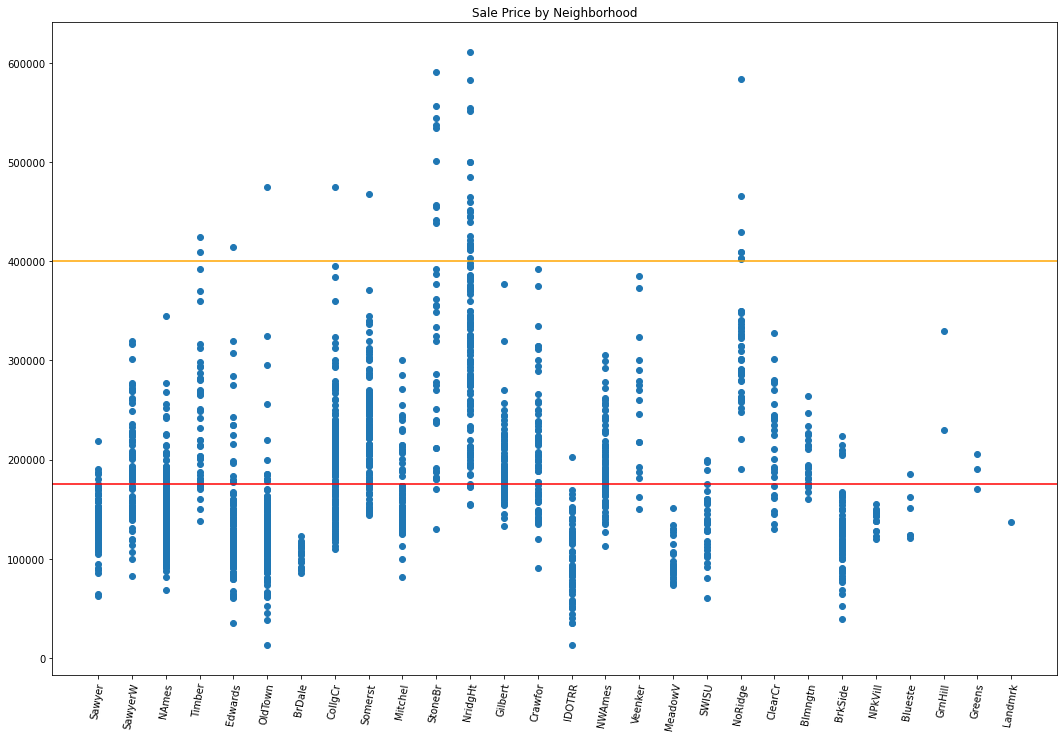

In [9]:
plt.figure(figsize=(18,12))
plt.title('Sale Price by Neighborhood')
plt.xticks(rotation=80)
plt.axhline(y=175_000, color='red')#setting some visual aids to group the neighborhoods by price
plt.axhline(y=400_000, color='orange')
#graph = sns.pairplot(home, y_vars='saleprice', x_vars=['neighborhood'], height=20)
plt.scatter(home['neighborhood'], home['saleprice']);

In [10]:
#https://www.delftstack.com/howto/matplotlib/how-to-plot-horizontal-and-vertical-line-in-matplotlib/

On the other hand... I could group neighbrohoods by price point. Geography may not be the most important feature for pricing, it could simply be name brand power.  
Some neighborhoods have a pretty wide range - they might not easily fit any "mean" bin (although maybe w/each other):  
-StoneBr  
-NridgHt  

In [11]:
#https://stackoverflow.com/questions/44787916/conditional-mean-over-a-pandas-dataframe
#https://stackoverflow.com/questions/21195179/plot-a-histogram-from-a-dictionary

In [12]:
med_dict = dict(home.groupby('neighborhood')['saleprice'].median().sort_values())
min_dict = dict(home.groupby('neighborhood')['saleprice'].min().sort_values())
max_dict = dict(home.groupby('neighborhood')['saleprice'].max().sort_values())
range_dict = dict(home.groupby('neighborhood')['saleprice'].max().sort_values() - home.groupby('neighborhood')['saleprice'].min().sort_values())

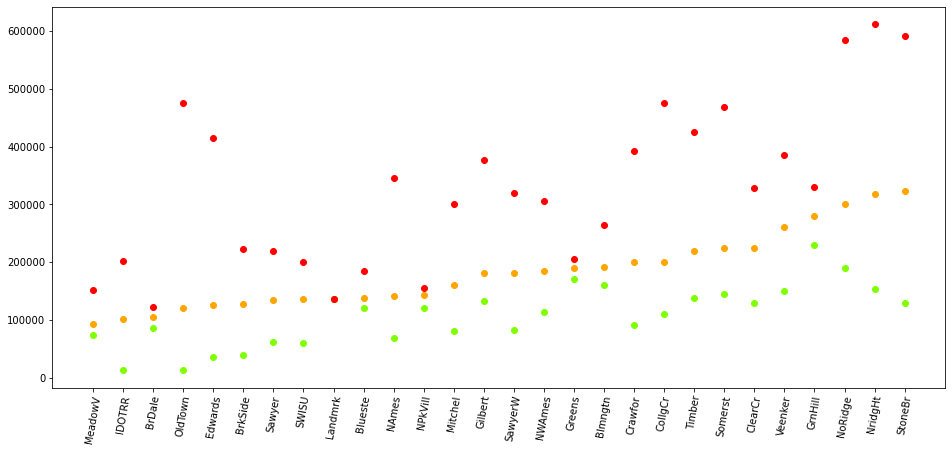

In [13]:
plt.figure(figsize=(16,7))
plt.xticks(rotation=80)
plt.scatter(med_dict.keys(), med_dict.values(), color = 'orange')
plt.scatter(min_dict.keys(), min_dict.values(), color = 'chartreuse')
plt.scatter(max_dict.keys(), max_dict.values(), color = 'red');
#plt.scatter(range_dict.keys(), range_dict.values(), color = 'blue');

Neighborhood grouping bins:  
-meadowV, Blueste, NpkVill, BrDale, Landmrk  
-IDOTRR, BrkSide, SWISU, Sawyer, Greens, Blmngtn  
-OldTown, Edwards  
-Mitchel, SawyerW, NAmes, Crawform, NWAmes  
-Veenker, Timber, Somerst, Gilbert, CollgCr  
-GrnHill, ClearCr  
-NridgeHt, StoneBr, NoRidge

Another way to try to be more precise/scientific about my groupings would be to come up with a metric by which these can be compared. Perhaps I can multiply min * median * max to create a new measure?

In [14]:
#https://stackoverflow.com/questions/47927695/pandas-multiply-using-dictionary-values-across-several-columns
#https://www.kite.com/python/answers/how-to-multiply-two-lists-in-python
#https://stackoverflow.com/questions/13704860/zip-lists-in-python

In [15]:
def n_metric(dict1, dict2, dict3):
    val1 = []
    val2 = []
    val3 = []
    final = []
    for keys, values in dict1.items():
        val1.append(values)
    for keys, values in dict2.items():
        val2.append(values)
    for keys, values in dict3.items():
        val3.append(values)
    for num1, num2, num3 in zip(val1, val2, val3):
        final.append(num1*num2*num3)
    return final

In [16]:
n_met_list = n_metric(med_dict, min_dict, max_dict)

In [17]:
len(n_met_list)

28

In [18]:
l1 = []
for keys, values in med_dict.items():
    l1.append(keys)
n_met = dict(zip(l1, n_met_list))

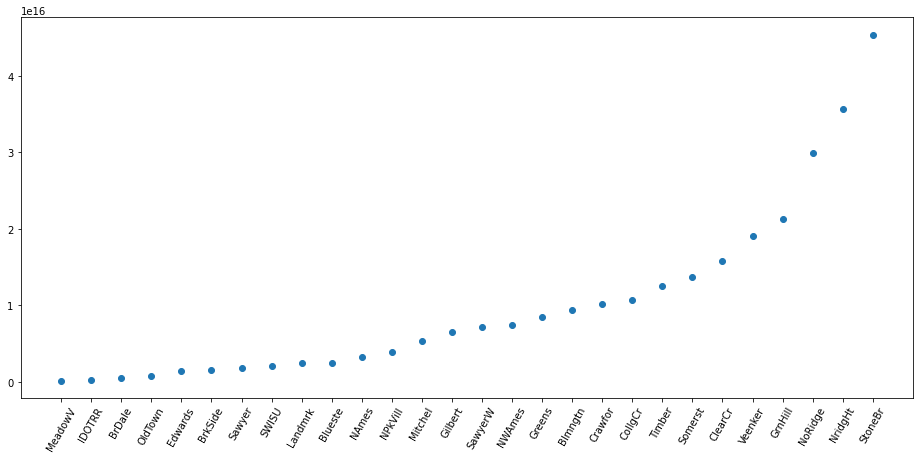

In [19]:
plt.figure(figsize=(16,7))
plt.xticks(rotation=60)
plt.scatter(n_met.keys(), n_met.values());

This is a scatter plot of my new metric (median price * max price * min price) per neighborhood. This is another way I could associate the neighborhoods. It looks like:  
- MeadowV, IDOTRR
- BRDale, OldTown
- Edwards, BrkSide, Sawyer
- SWISU, Landmrk, Blueste
- NAmes, NPKVill
- Mitchel
- Gilbert, SawyerW, NWAmes
- Greens, Blmngtn, CollgCr
- Timber, Somerst
- ClearCr
- Veenker, GrnHill
- NoRidge
- NridgeHt
- StoneBr

### BldgType: Type of dwelling

-   1Fam Single-family Detached

-   2FmCon Two-family Conversion; originally built as one-family dwelling

-   Duplx Duplex

-   TwnhsE Townhouse End Unit

-   TwnhsI Townhouse Inside Unit

In [20]:
home['bldg_type'].value_counts()

1Fam      1700
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: bldg_type, dtype: int64

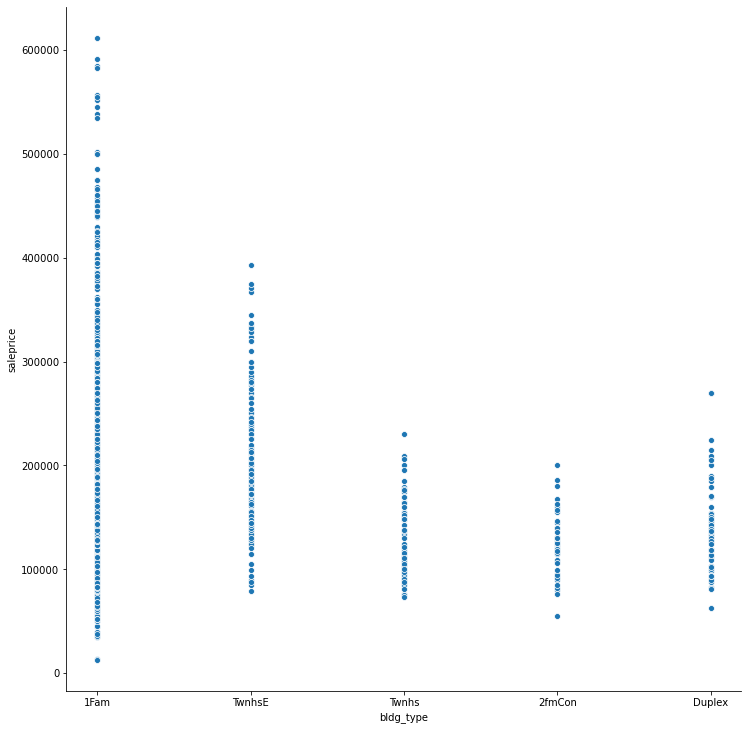

In [21]:
sns.pairplot(home, y_vars='saleprice', x_vars=['bldg_type'], height=10);

Good distribution, definitely worth including.

### HouseStyle: Style of dwelling

-   1Story One story

-   1.5Fin One and one-half story: 2nd level finished

-   1.5Unf One and one-half story: 2nd level unfinished

-   2Story Two story

-   2.5Fin Two and one-half story: 2nd level finished

-   2.5Unf Two and one-half story: 2nd level unfinished

-   SFoyer Split Foyer

-   SLvl Split Level

In [22]:
home['house_style'].value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

C:\Users\willg\anaconda3\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


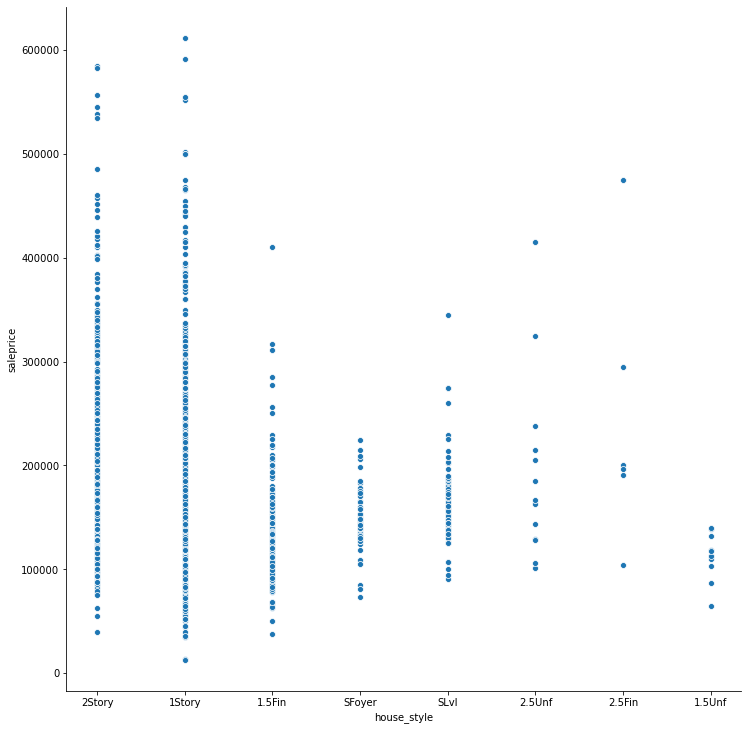

In [23]:
#plt.figure(figsize=(12,5))
sns.pairplot(home, y_vars='saleprice', x_vars=['house_style'], size=10);

I'm going to hold back on this feature...If I do use it I will have to combine some of the smaller columns. Based on the pairplot it seems like there are values at every price point for almost every category. It does look like 1.5 unfinished and sfoyer properties tend to be lower, and 1.5fin, 2.5fin, and 2.5unfin are sort of in the same range? Not conclusive, not worth cleaning right now.

### ExterCond: Present condition of the material on the exterior

-   Ex Excellent

-   Gd Good

-   TA Average/Typical

-   Fa Fair

-   Po Poor

In [24]:
home['exter_cond'].value_counts()

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64

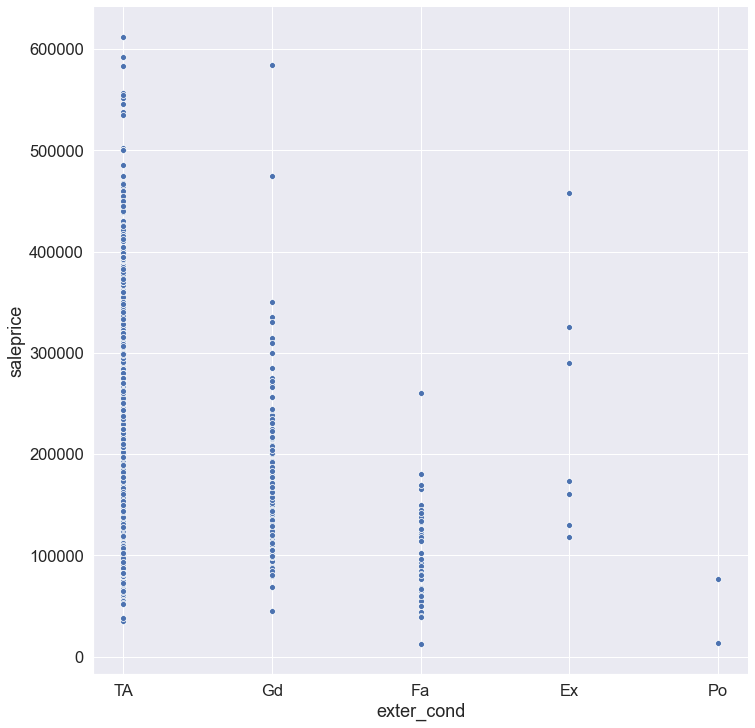

In [106]:
sns.set(font_scale=1.5)
sns.pairplot(home, y_vars='saleprice', x_vars=['exter_cond'], height=10);
#plt.savefig('./images/ex_pairplot.png', dpi=200, bbox_inches='tight');

Again, not seeing any obvious relationship between conditions and price, seems like all conditions for the most part run across all price ranges, with the exception of poor but there are so few points there it's probably not significant. I'm going to skip this one.

### Heating: Type of heating

-   Floor Floor Furnace

-   GasA Gas forced warm air furnace

-   GasW Gas hot water or steam heat

-   Grav Gravity furnace

-   OthW Hot water or steam heat other than gas

-   Wall Wall furnace

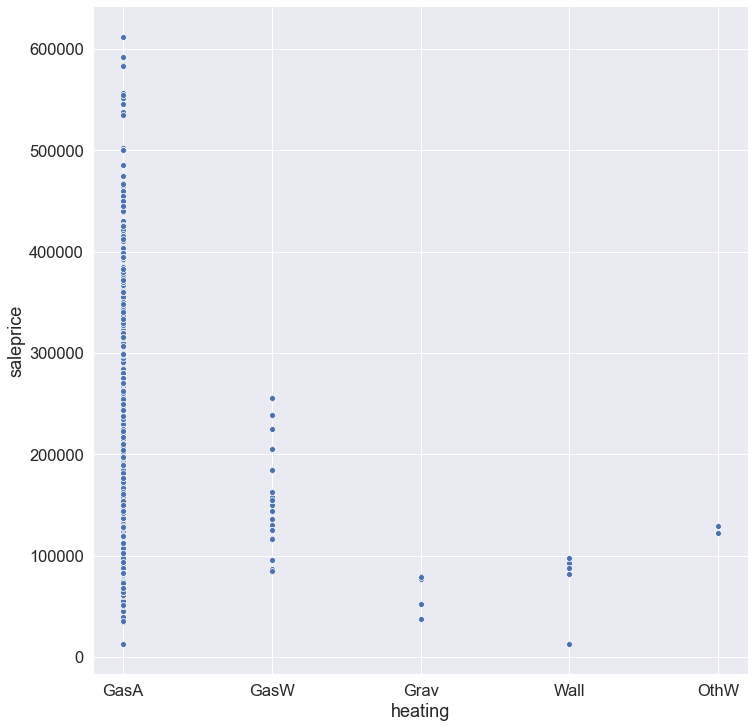

In [105]:
sns.set(font_scale=1.5)
sns.pairplot(home, y_vars='saleprice', x_vars=['heating'], height=10);
#plt.savefig('./images/heat_pairplot.png', dpi=200, bbox_inches='tight');

This shows some promise - the 3 right-most variables seem grouped on the lower price end, GasW is betwen 100k-300k, and then GasA (the majority) runs the full gamut. I could make 3 bins out of this category:  
- Grav heating, Wall, OthW
- GasW
- GasA

### CentralAir: Central air conditioning

-   N No

-   Y Yes

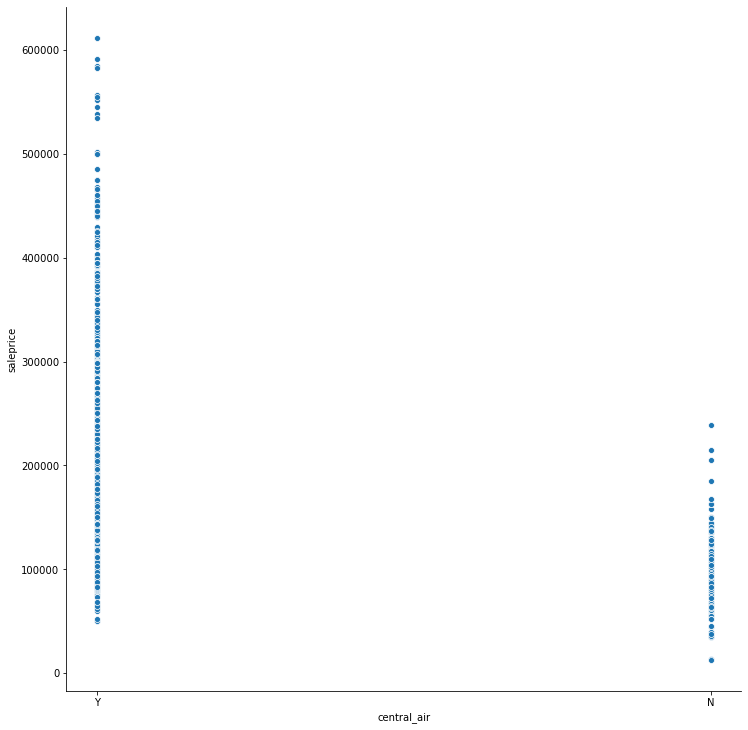

In [27]:
sns.pairplot(home, y_vars='saleprice', x_vars=['central_air'], height=10);

Simple, binary variable, and seemingly the "N" option constitutes a generally lower price than "Y". Worth including.

### KitchenQual: Kitchen quality

-   Ex Excellent

-   Gd Good

-   TA Typical/Average

-   Fa Fair

-   Po Poor

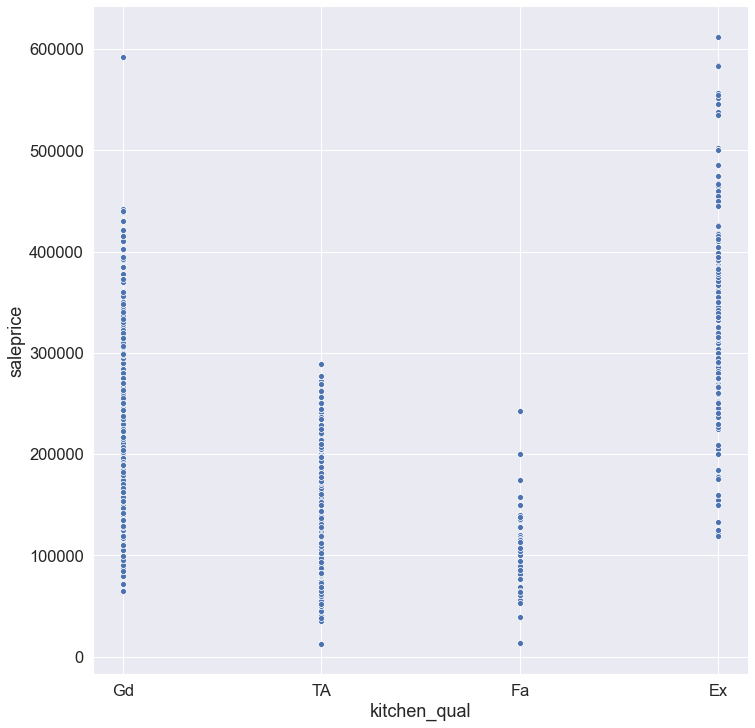

In [110]:
sns.set(font_scale=1.5)
sns.pairplot(home, y_vars='saleprice', x_vars=['kitchen_qual'], height=10);
#plt.savefig('./images/k_pairplot.png', dpi=200, bbox_inches='tight');

There is decent grouping between the 4 possibilities (no poor values). I'll combine poor with fair in an "else" category (just in case there are any poor values in the test set) and include this one, at least to start.

### MoSold: Month Sold

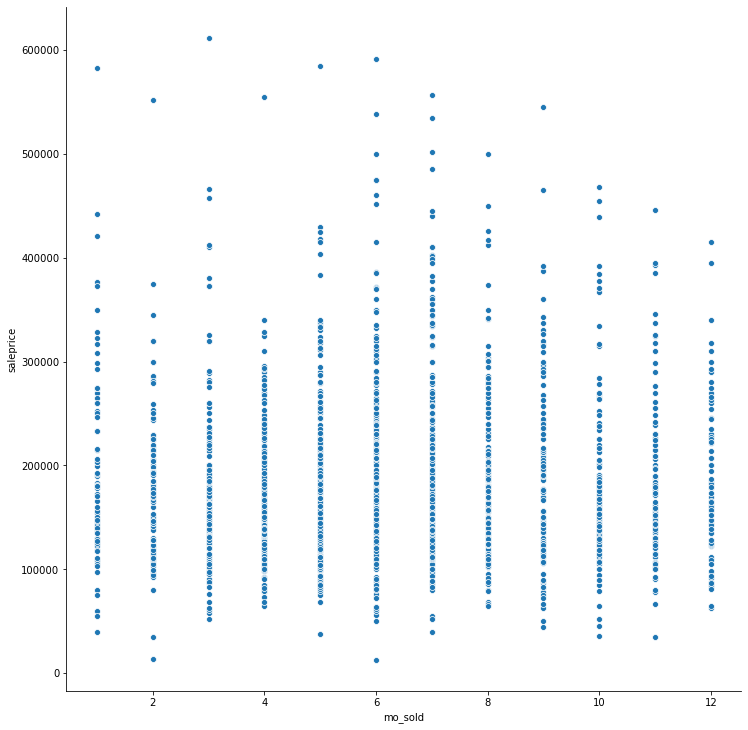

In [29]:
sns.pairplot(home, y_vars='saleprice', x_vars=['mo_sold'], height=10);

Not seeing a strong pattern here. Skip for now.

### Fence: Fence quality

-   GdPrv Good Privacy

-   MnPrv Minimum Privacy

-   GdWo Good Wood

-   MnWw Minimum Wood/Wire

-   NA No Fence

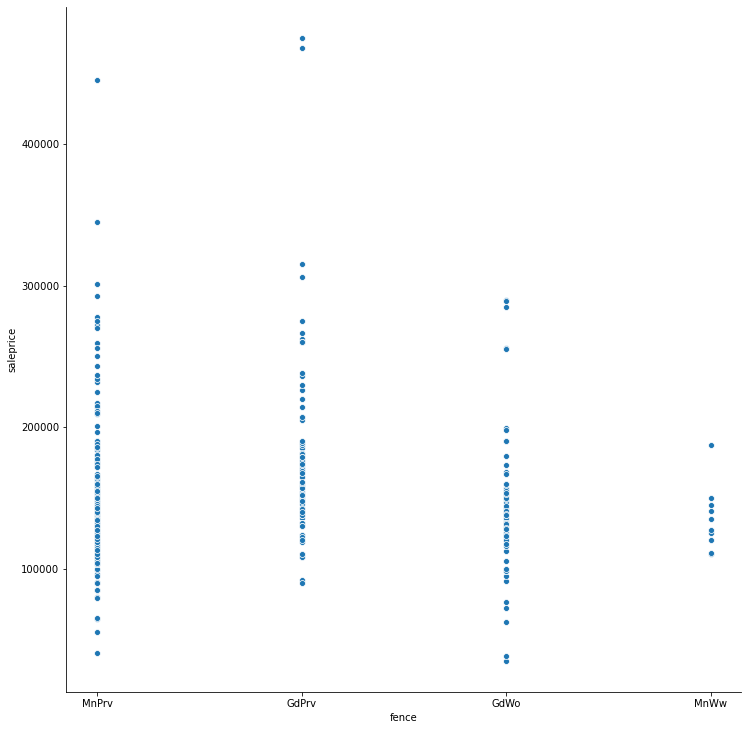

In [30]:
sns.pairplot(home, y_vars='saleprice', x_vars=['fence'], height=10);

YrSold: Year Sold

No strong significance visible here. Skip.

### SaleType: Type of sale

-   WD Warranty Deed - Conventional

-   CWD Warranty Deed - Cash

-   VWD Warranty Deed - VA Loan

-   New Home just constructed and sold

-   COD Court Officer Deed/Estate

-   Con Contract 15% Down payment regular terms

-   ConLw Contract Low Down payment and low interest

-   ConLI Contract Low Interest

-   ConLD Contract Low Down

-   Oth Other

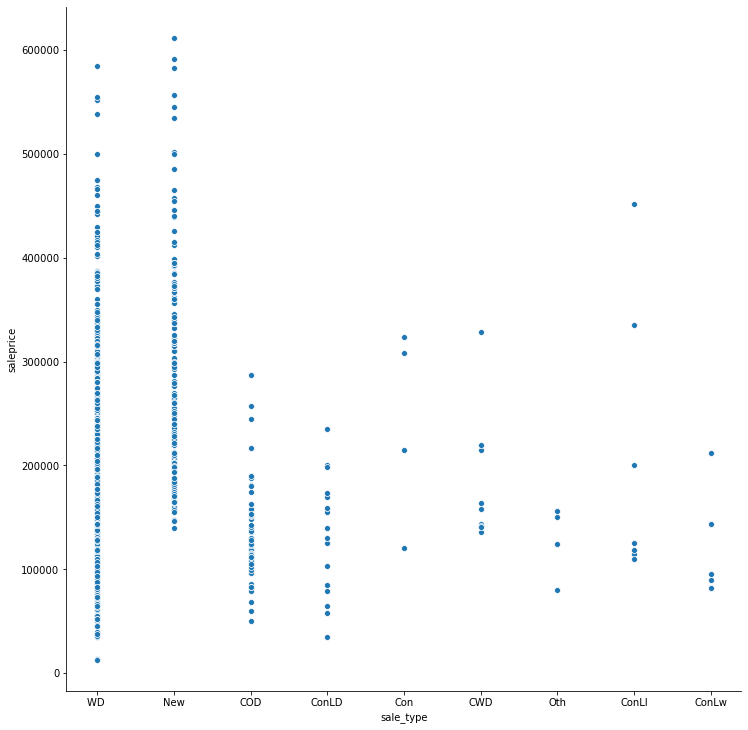

In [31]:
sns.pairplot(home, y_vars='saleprice', x_vars=['sale_type'], height=10);

I can make a couple bins here and see how we do. No VWD in the train data so I'll have to add it in somewhere... WD probably. Looks like:  
- Oth, ConLi, ConLW
- CWD, Con
- COD, ConLD
- New
- WD, VWD

## Recap  
Categorical Variables Selected for First Run Through Based on Analysis Above
- MSZoning
    - I (all), A (agr), C (all)
    - RH
    - FV
    - RM
    - RL, RP
- Neighborhood
    - MeadowV, IDOTRR
    - BRDale, OldTown
    - Edwards, BrkSide, Sawyer
    - SWISU, Landmrk, Blueste
    - NAmes, NPKVill
    - Mitchel
    - Gilbert, SawyerW, NWAmes
    - Greens, Blmngtn, CollgCr
    - Timber, Somerst
    - ClearCr
    - Veenker, GrnHill
    - NoRidge
    - NridgeHt
    - StoneBr
- BldgType: Type of dwelling (no combining needed)
    - 1Fam Single-family Detached
    - 2FmCon Two-family Conversion; originally built as one-family dwelling
    - Duplx Duplex
    - TwnhsE Townhouse End Unit
    - TwnhsI Townhouse Inside Unit
- Heating: Type of heating
    - Grav heating, Wall, OthW
    - GasW
    - GasA
- CentralAir: Central air conditioning (no combining needed)
    - N No
    - Y Yes
- KitchenQual: Kitchen quality
    - Ex Excellent
    - Gd Good
    - TA Typical/Average
    - Fa Fair, Po Poor
- SaleType: Type of sale
    - Oth, ConLi, ConLW
    - CWD, Con
    - COD, ConLD
    - New
    - WD, VWD

I need to work out a way to combine the columns/categories that I think belong together. I'm going to make a copy of my dataframe before I start trying some methods, just in case I make a mistake.

In [32]:
#https://stackoverflow.com/questions/19226488/change-one-value-based-on-another-value-in-pandas

In [33]:
home2 = home.copy()

In [34]:
home2['ms_zoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

- MSZoning
    - I (all), A (agr), C (all)
    - RH
    - FV
    - RM
    - RL, RP

In [35]:
home2['ms_cat'] = 'other' #making a new column for zone categories

In [36]:
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types

In [37]:
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'

In [38]:
#home2.loc[home2['ms_cat'] == 0, 'ms_cat']='zone5' #anything not included in prior zones will go into zone5. right now that's just RL
#what is left over will be 'other' and contain RL + anything that hasn't been accounted for by the other filters (like maybe RP)

In [39]:
#home2['ms_cat'].value_counts().sum() #got 'em all!

In [40]:
#home2['neighborhood'].value_counts()

- Neighborhood
    - MeadowV, IDOTRR
    - BRDale, OldTown
    - Edwards, BrkSide, Sawyer
    - SWISU, Landmrk, Blueste
    - NAmes, NPKVill
    - Mitchel
    - Gilbert, SawyerW, NWAmes
    - Greens, Blmngtn, CollgCr
    - Timber, Somerst
    - ClearCr
    - Veenker, GrnHill
    - NoRidge
    - NridgeHt
    - StoneBr

In [41]:
home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"

In [42]:
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'

home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'

home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'

home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'

home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'

home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'

home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'

#home2.loc[(home2['neighborhood'] == 'Greens') | (home2['neighborhood'] == 'Blmngtn') | (home2['neighborhood'] == 'CollgCr'), 'n_cat']='zone8' 
#I'm going to let this just be "other"; it's going to be a large category so if we happen to have any odd neighborhoods not listed, they wont change this too much

home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'

home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'

home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'

home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'

home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'

home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

- Heating: Type of heating
    - Grav heating, Wall, OthW
    - GasW
    - GasA

In [43]:
home2['heating'].value_counts()

GasA    2018
GasW      20
Wall       6
Grav       5
OthW       2
Name: heating, dtype: int64

In [44]:
home2['h_cat'] = 'other'

In [45]:
home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'

home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'

#the other 3 categories will stay together as "other"

In [46]:
#home2['h_cat'].value_counts()

- KitchenQual: Kitchen quality
    - Ex Excellent
    - Gd Good
    - TA Typical/Average
    - Fa Fair, Po Poor

In [47]:
home2['kitchen_qual'].value_counts()

TA    1047
Gd     806
Ex     151
Fa      47
Name: kitchen_qual, dtype: int64

In [48]:
home2['k_cat'] = 'other'

home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'

home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'

home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'

#Fair + any poors in the test set will stay as 'other'

home2['k_cat'].value_counts()

TA       1047
Gd        806
Ex        151
other      47
Name: k_cat, dtype: int64

- SaleType: Type of sale
    - Oth, ConLi, ConLW
    - CWD, Con
    - COD, ConLD
    - New
    - WD, VWD

In [49]:
home2['sale_type'].value_counts()

WD       1781
New       160
COD        63
ConLD      17
CWD        10
ConLI       7
ConLw       5
Oth         4
Con         4
Name: sale_type, dtype: int64

In [50]:
home2['st_cat'] = 'other'

home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'

home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'

home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'

home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld'

home2['st_cat'].value_counts()

#WD plus any other unrepresented categories (like VWD) will fall into "other"

other    1781
New       160
cld        80
occ        16
cwn        14
Name: st_cat, dtype: int64

### Okay!  
All these categorical features should be ready to be dummified for our first model with them.

In [51]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat']

In [56]:
X = home2[cat_features]
X = pd.get_dummies(X, columns=cat_features, drop_first=True)


In [57]:
y = home2['saleprice']

In [60]:
lr = LinearRegression()
lr.fit(X, y)
lr.score(X, y)
pred = lr.predict(X)
print(f'Your RMSE for test is {metrics.mean_squared_error(y, pred)**.5}.')

Your RMSE for test is 44568.50222476107.


In [61]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, feature_list, dum_cols):
    X = df[feature_list].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    lr.score(X, y)
    pred = lr.predict(X)
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [62]:
make_model(home2, 'all_cat', cat_features, cat_features)

'Your RMSE for test all_cat is 44568.50222476107.'

Okay, so that's not better than my numerical but it's doing something. Time to combine ALL the filters and see how I do.

I'm going to see if removing any of these improves my train RMSE:

In [63]:
#original list scored 44568 cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat']
#scored 44686 cat_features = ['n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat']
# scored 45860 cat_features = ['ms_cat', 'n_cat', 'h_cat', 'central_air', 'k_cat', 'st_cat']
# scored 44631 cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'central_air', 'k_cat', 'st_cat']

I was not able to find any configuration of these variables in their current state that imrpoves over my initial score.  
I'm going to go back over to the numberical filters and see what improvements I can make on that side. I'll probably revisit these again in the future.

In [64]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X)
    #pred = [n*1for n in pred]
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

I want this to be better! I'm going to add 2 more categorical variables that I skipped on my first run through:  
- ExtrCond
- HouseStyle  

I'll have to group them as I did the others...

### ExterCond: Present condition of the material on the exterior

-   Ex Excellent

-   Gd Good

-   TA Average/Typical

-   Fa Fair

-   Po Poor

In [65]:
home2['exter_cond'].value_counts()

TA    1778
Gd     215
Fa      49
Ex       7
Po       2
Name: exter_cond, dtype: int64

I'm going to group these like this:  
-  exter_cond
    - Fa, Po
    - Gd, Ex
    - TA

In [66]:
home2['ex_cat'] = 'other'
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'
#the TA class will by my "other"

In [67]:
home2['ex_cat'].value_counts()

other    1778
GdEx      222
FaPo       51
Name: ex_cat, dtype: int64

### HouseStyle: Style of dwelling

-   1Story One story

-   1.5Fin One and one-half story: 2nd level finished

-   1.5Unf One and one-half story: 2nd level unfinished

-   2Story Two story

-   2.5Fin Two and one-half story: 2nd level finished

-   2.5Unf Two and one-half story: 2nd level unfinished

-   SFoyer Split Foyer

-   SLvl Split Level

In [68]:
home2['house_style'].value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: house_style, dtype: int64

I'm going to group these as follows:  
- house_style
    - SFoyer, 1.5Unf
    - 1.5Fin, SLvl
    - 2.5Unf, 2.5Fin
    - 1Story, 2Story

In [69]:
home2['hs_cat'] = 'other'
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
#1story and 2 story will be my 'other's

In [70]:
home2.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,yr_sold,sale_type,saleprice,ms_cat,n_cat,h_cat,k_cat,st_cat,ex_cat,hs_cat
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,2010,WD,130500,other,zone3,GasA,Gd,other,other,other
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,2009,WD,220000,other,zone7,GasA,Gd,other,other,other
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,2010,WD,109000,other,zone5,GasA,Gd,other,GdEx,other
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,2010,WD,174000,other,zone9,GasA,TA,other,other,other
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,2010,WD,138500,other,zone7,GasA,TA,other,other,15FSL


Okay, lets try the model again with these 2 additional features and check if there is any improvement.

In [71]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat']

In [72]:
#make_model(home2, 'all_cat2', cat_features, cat_features)

Well, this brought my train RMSE down about 500 points. I'm going to add this in with my numerical changes and see if it helps my overall RMSE

...some time later ...

In my numeric values notebook, the mas_vnr_area column proved helpful. I wonder if there's any value in the mas_vnr_type category?

In [73]:
home2['mas_vnr_type'].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [74]:
home2['mas_vnr_type'].isnull().sum()

22

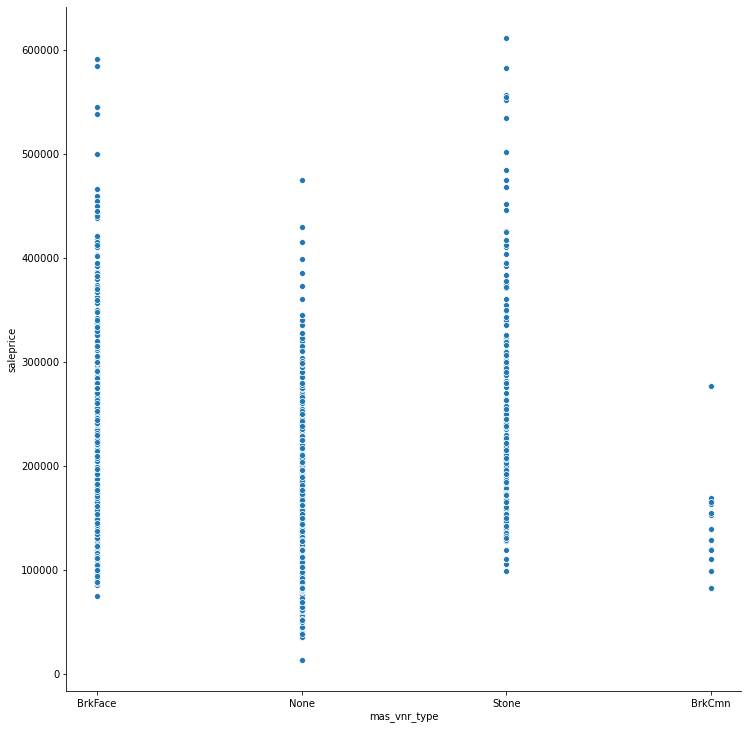

In [75]:
sns.pairplot(home, y_vars='saleprice', x_vars=['mas_vnr_type'], height=10);

Looks like BrkFace and Stone might add some value to the price.  
I'll put the two bricks together, Stone on it's own, and None as my catch-all 'other" column:
- mas_vnr_type
    - BrkFace, BrkCmn
    - Stone
    - None (other)

In [76]:
home2['mas_cat'] = 'other'
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
#other will include "None", nans, and any potential cinderblock houses (none in test data)

In [77]:
home2['mas_cat'].value_counts()

other    1240
Brk       643
Stone     168
Name: mas_cat, dtype: int64

In [78]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat', 'mas_cat']

In [79]:
#make_model(home2, 'all_cat2', cat_features, cat_features)

WOAH! That brought my RMSE down 1.5k! Time to make another model...

...some time later...

I want to revisit my neighborhood metric to see if I can categorize them better than my somewhat arbitrary 3-number-product coding method. Let's bring back the graph of min, median, and max based on neighborhood:

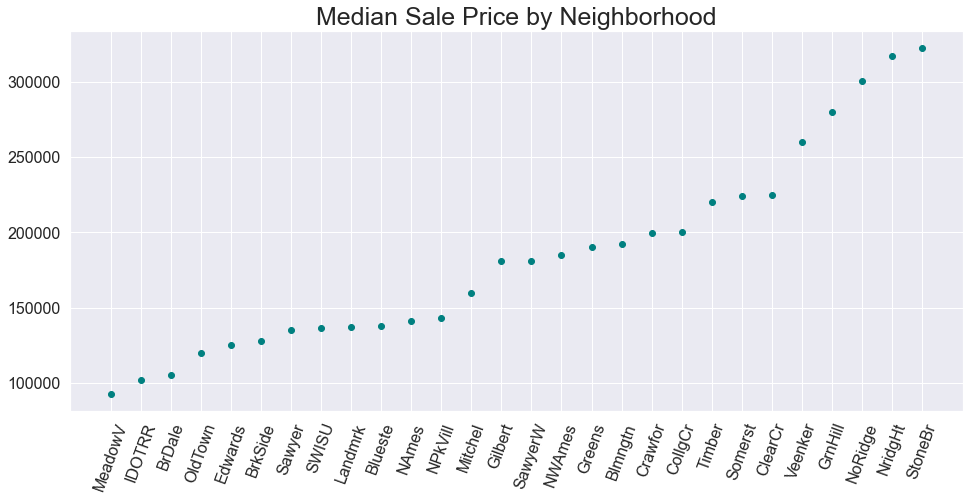

In [109]:
plt.figure(figsize=(16,7))
plt.xticks(size=16, rotation=70)
plt.yticks(size=16)
plt.title('Median Sale Price by Neighborhood', size=25)
plt.scatter(med_dict.keys(), med_dict.values(), color = 'teal');
#plt.savefig('./images/n_scatter.png', dpi=200, bbox_inches='tight');
#plt.scatter(min_dict.keys(), min_dict.values(), color = 'chartreuse')
#plt.scatter(max_dict.keys(), max_dict.values(), color = 'red');

In [81]:
home2['neighborhood'].value_counts()

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
Timber      48
NoRidge     48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
NPkVill     17
Veenker     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: neighborhood, dtype: int64

I'd like to group any neighborhoods with fewer than 20 representatives. Aside from that, hopefully by creating more unique neighborhood buckets, my model will get a little smarter. That would mean grouping:  
- Landmrk
- GrnHill
- Greens
- Blueste
- NPkVill
- Veenker
- BrDale  

This should result in 28-7=21 unique neighborhood columns. I will split them up based on the median table (in cell below):  

- MeadowV
- IDOTRR, BrDale (combined)
- OldTown
- Edwards
- BrkSide
- Sawyer
- SWISU, Landmrk, Blueste (combined)
- NAmes, NPkVill (combined)
- Mitchel
- Gilbert
- SawyerW
- NWAmes
- Greens, Blmngtn (combined)
- Crawfor
- CollgCr
- Timber
- Somerst
- ClearCr, Veenker (combined)
- GrnHill, NoRidge (combined)
- NridgeHt
- StoneBr

In [82]:
home2.groupby('neighborhood')['saleprice'].median().sort_values()

neighborhood
MeadowV     92450
IDOTRR     102000
BrDale     105500
OldTown    120000
Edwards    125000
BrkSide    128000
Sawyer     135000
SWISU      136200
Landmrk    137000
Blueste    137500
NAmes      141000
NPkVill    143000
Mitchel    160000
Gilbert    180750
SawyerW    181000
NWAmes     185000
Greens     190000
Blmngtn    192250
Crawfor    199500
CollgCr    200000
Timber     220000
Somerst    224000
ClearCr    225000
Veenker    260000
GrnHill    280000
NoRidge    300750
NridgHt    317500
StoneBr    322450
Name: saleprice, dtype: int64

Now I need to code that out:

In [83]:
#home2['n_cat'] = 0 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into 0
home2.loc[(home2['neighborhood'] == 'IDOTRR') | (home2['neighborhood'] == 'BrDale'), 'neighborhood']='IDOBD'

home2.loc[ (home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk')
          | (home2['neighborhood'] == 'Blueste'), 'neighborhood']='SWLB'

home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPkVill'), 'neighborhood']='NAPV'

home2.loc[(home2['neighborhood'] == 'Greens') | (home2['neighborhood'] == 'Blmngtn'), 'neighborhood']='GB'

home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'ClearCr'), 'neighborhood']='VCC'

home2.loc[(home2['neighborhood'] == 'NoRidge') | (home2['neighborhood'] == 'GrnHill'), 'neighborhood']='NRGH'


In [84]:
home2['neighborhood'].value_counts()

NAPV       327
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
IDOBD       88
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
NRGH        50
Timber      48
VCC         44
SWLB        39
StoneBr     38
GB          25
MeadowV     24
Name: neighborhood, dtype: int64

Great, that worked! Now I've got my 21 neighborhoods / neighborhood groups, I'm going to add this code to my cleaner file.

ALTERNATE - I want to calculate IQR for each neighborhood - see if that creates different/decent groups.

In [85]:
#code i have saved for iqr operations
#df['col1'].quantile([.25, .75][1]) - df['col1'].quantile([.25, .75][0])
#got help from Dan W. in OH for this IQR calculation

In [86]:
home.groupby('neighborhood')['saleprice'].quantile([.25,.75])

neighborhood      
Blmngtn       0.25    180250.00
              0.75    218742.50
Blueste       0.25    123925.00
              0.75    159625.00
BrDale        0.25     93750.00
              0.75    111875.00
BrkSide       0.25    109375.00
              0.75    139975.00
ClearCr       0.25    177500.00
              0.75    250500.00
CollgCr       0.25    164740.00
              0.75    225250.00
Crawfor       0.25    158250.00
              0.75    235250.00
Edwards       0.25    101000.00
              0.75    142500.00
Gilbert       0.25    172281.25
              0.75    193625.00
Greens        0.25    180000.00
              0.75    198000.00
GrnHill       0.25    255000.00
              0.75    305000.00
IDOTRR        0.25     72000.00
              0.75    126000.00
Landmrk       0.25    137000.00
              0.75    137000.00
MeadowV       0.25     84875.00
              0.75    117250.00
Mitchel       0.25    136375.00
              0.75    188000.00
NAmes         0.25   

In [87]:
home.groupby('neighborhood')['saleprice'].agg(lambda x: x.quantile(.75) - x.quantile(.25)).sort_values()

neighborhood
Landmrk         0.00
NPkVill     11000.00
Greens      18000.00
BrDale      18125.00
Gilbert     21343.75
Sawyer      25400.00
BrkSide     30600.00
NAmes       31000.00
MeadowV     32375.00
OldTown     35625.00
Blueste     35700.00
Blmngtn     38492.50
Edwards     41500.00
NWAmes      43125.00
SWISU       46483.50
GrnHill     50000.00
Mitchel     51625.00
IDOTRR      54000.00
NoRidge     57875.00
CollgCr     60510.00
ClearCr     73000.00
SawyerW     73630.00
Somerst     76875.00
Crawfor     77000.00
Veenker     98000.00
Timber     101034.75
NridgHt    119761.50
StoneBr    208960.00
Name: saleprice, dtype: float64

These are my IQRs for each neighborhood. Landrk has a zero because it only has one value (below) of 137,000. I'm concerned about this method of measurement because while it represents the range of prices in each neighborhood but I'm not sure it's a great measure for my purposes. Two neighborhoods could in theory have the same IQR number but markedly different contributing sale prices. An interesting experiment but I'm going to pass on putting it into my model.

In [88]:
(home2.loc[home2['neighborhood']=='Landmrk']['saleprice'])

Series([], Name: saleprice, dtype: int64)

I had an idea for a new column that is a concatenation of zone and neighborhood - I want to create it and then graph to see how it looks.

In [89]:
home2['n_cat']

0       zone3
1       zone7
2       zone5
3       zone9
4       zone7
        ...  
2046    zone9
2047    zone3
2048    other
2049    zone5
2050    zone7
Name: n_cat, Length: 2051, dtype: object

In [90]:
#home2['nz'] = home2['neighborhood'] + home2['ms_zoning']
home2['nz'] = home2['n_cat'] + home2['ms_cat']

In [91]:
home2['nz']

0       zone3other
1       zone7other
2       zone5other
3       zone9other
4       zone7other
           ...    
2046    zone9other
2047    zone3other
2048    otherother
2049    zone5other
2050    zone7other
Name: nz, Length: 2051, dtype: object

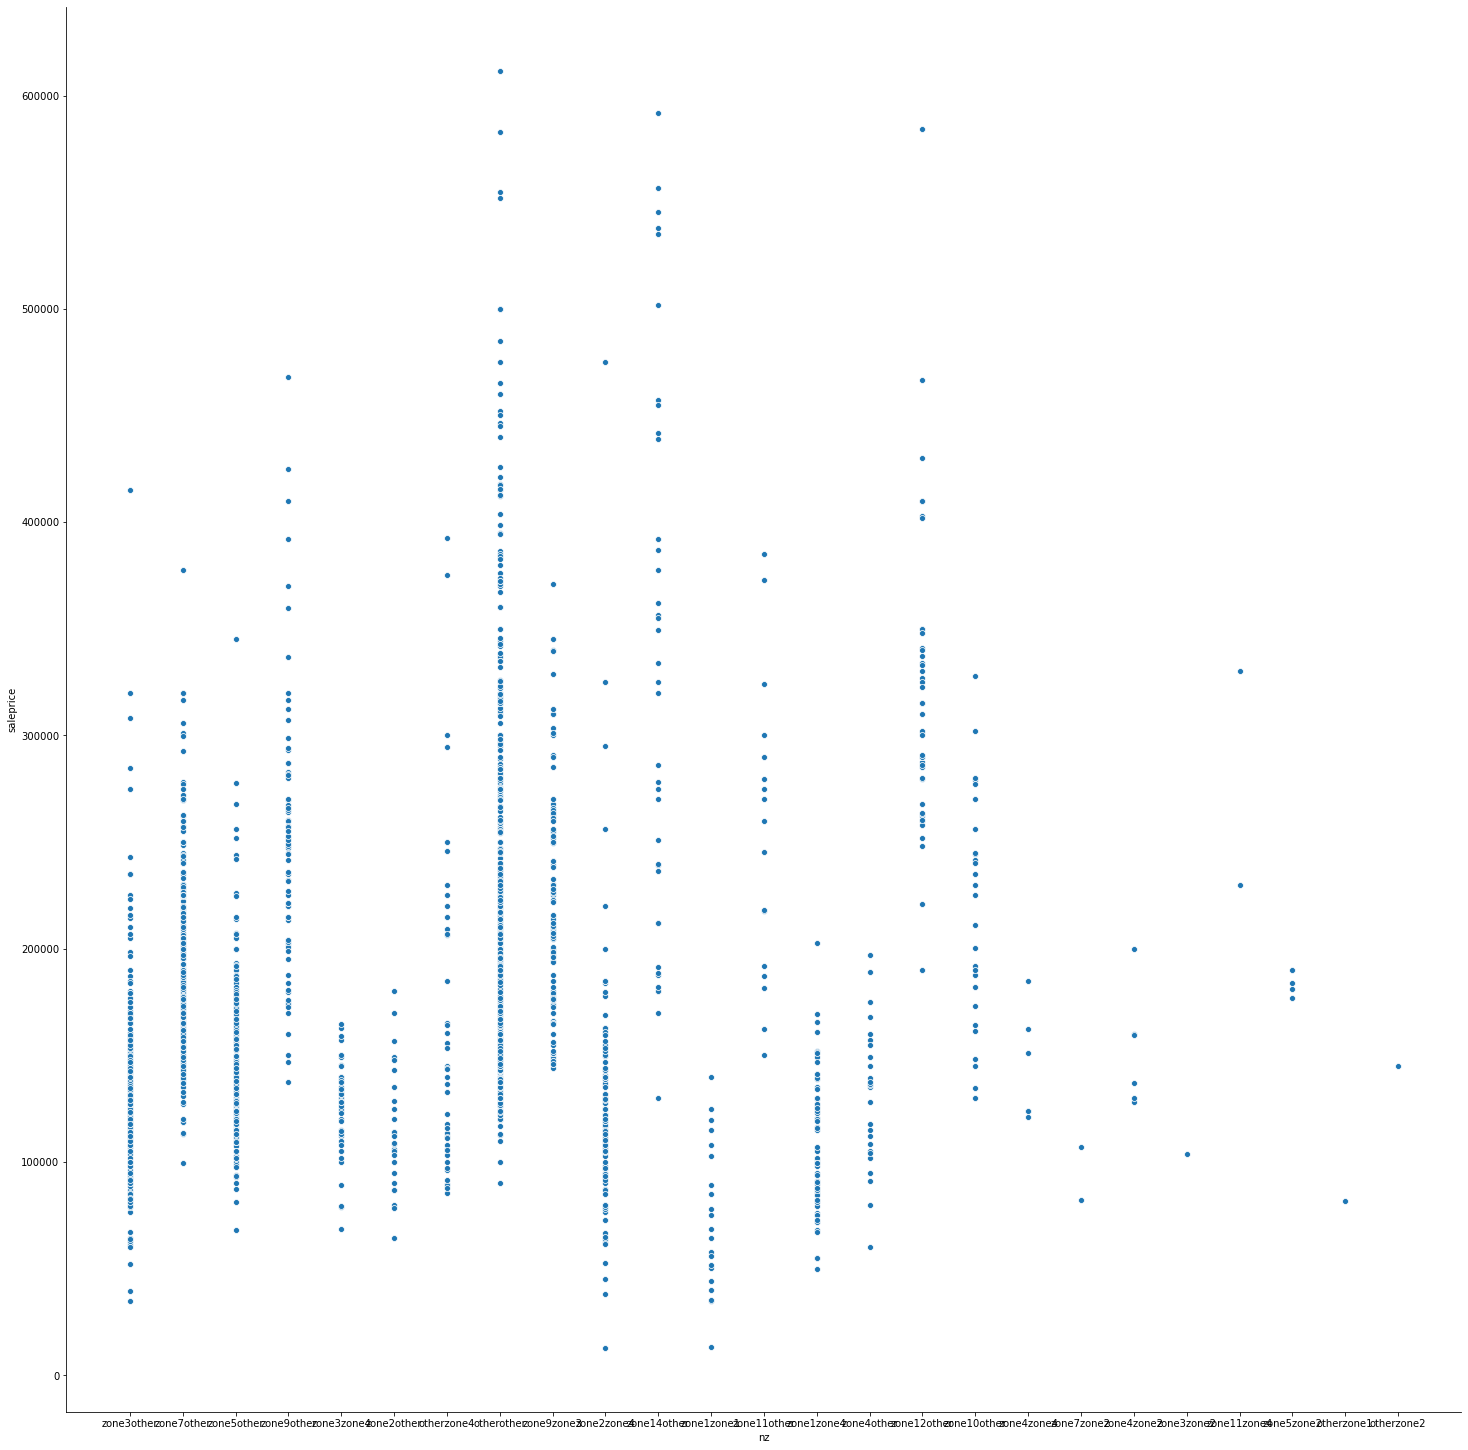

In [96]:
sns.pairplot(home2, y_vars='saleprice', x_vars=['nz'], height=20);

This initially seemed like a promising feature but ultimately I cut it from what proved to be my best model.